
<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(100%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    Mini-Challenge 1:<br>Hyperparameter und Model Tuning 
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Gabriel Torres Gamez im FS 2023.
</p>

<p style="clear: both; text-align: left;">
    Link zum Bericht: <a href="https://api.wandb.ai/links/gabrieltorresgamez/0pfj0qo0">https://api.wandb.ai/links/gabrieltorresgamez/0pfj0qo0</a>
</p>

## Ziel 

<p style="width:800px;">
Implementiere, trainiere und validiere ein Neuronales Netzwerk Modell für einen Klassifikationstask mit geeignetem Dataset. 
Der zu modellierende Task und die dazu passenden Daten sollen am Anfang der Mini-Challenge individuell vereinbart werden. 
Dabei können die Studierenden auch ihre Wünsche einbringen und Task/Datensatz vorschlagen. 
Dabei ist aber darauf zu achten, dass der Fokus auf das Training und die Evaluation gelegt und nicht zu viel Zeit mit Datenbeschaffung, -Analyse und -Vorverarbeitung verbraucht wird. 
Der Datensatz sollte auch nicht zu gross sein, um viele verschiedene Modell- und Parametervarianten evaluieren zu können. 
Ausserdem sollten nicht zu ausgeklügelte komplexe Modell-Architekturen untersucht werden. 
Ein MLP für die Klassifikation allenfalls mit ein paar CNN-Layern für Feature-Extraktion sollte ausreichen.
</p>

## Schritt 1: Auswahl Task / Datensatz 

1. Mache Dir Gedanken, mit welchen Daten Du arbeiten möchtest und welcher Task gelernt werden soll. 

2. Diskutiere die Idee mit dem Fachcoach.

In [1]:
# 1.
# Ich werde in der Challenge den CIFAR-10 Datensatz verwenden.
# Der CIFAR-10 Datensatz beinhaltet 60'000 Bilder mit 32x32 Pixeln in 3 Farbkanälen.
# Die Bilder sind in 10 Klassen unterteilt.
# Die Klassen sind: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.
# Die Bilder sind in 50'000 Trainingsbilder und 10'000 Testbilder unterteilt.
# Mit diesem Datensatz kann ich ein Modell trainieren, welches Bilder in die richtige Klasse einordnet.

# 2.
# Der Fachcoach segnet diese Aufgabe ab. :)
# Ich werde die Aufgabe mit PyTorch lösen.
# Ich werde mich an den Lernmaterialien von Francois Fleuret und des MSE Kurses orientieren.
# Link zum Kurs von Francois Fleuret: https://fleuret.org/dlc/
# Link zu den MSE Kursfolien: https://gitlab.fhnw.ch/deep_learning/sgds/resources/-/tree/master/mse_lecture_slides_fs22
# Link zu den MSE Kursrecordings: https://gitlab.fhnw.ch/deep_learning/sgds/resources/-/blob/master/mse_lecture_slides/MSE_DL_Recordings_SS21.pdf

## Schritt 2: Daten Kennenlernen 

1. Mache Dich mit dem Datensatz vertraut, indem Du eine (kurze) explorative Analyse 
der Features durchführst: z.B. Vergleich der Klassen pro Feature, Balanciertheit der 
Klassen. 

2. Führe ein geeignetes Preprocessing durch, z.B. Normalisierung der Daten. 

In [2]:
# import libraries
import logging
import warnings

import torch
import torchvision

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import wandb
from manager import Manager

# print information about the environment
print("Packages: ")
print(f" | PyTorch Version: {torch.__version__}")
print(f" | Torchvision Version: {torchvision.__version__}")
print(f" | Numpy Version: {np.__version__}")
print(f" | Matplotlib Version: {mpl.__version__}")
print(f" | Wandb Version: {wandb.__version__}")
print()

print("Backends: ")
print(f" | CUDA: {torch.cuda.is_available()}")
print(f"  | CUDA Built: {torch.backends.cuda.is_built()}")
print(f" | MPS: {torch.backends.mps.is_available()}")
print(f"  | MPS Built: {torch.backends.mps.is_built()}")
print()

print("Ressources: ")
print(f" | CPU Cores: {torch.get_num_threads()}")
print(f" | GPU Cores: {torch.cuda.device_count()}\n")

# set settings
if torch.cuda.is_available(): # NVIDIA GPU's
    device = "cuda"
elif torch.backends.mps.is_available(): # Apple M SOC's
    device = "mps"
else:
    device = "cpu"

print(f"Using Device: {device}\n")

# silent wandb
%env WANDB_SILENT=True

# silent warnings and pytorch lightning
warnings.filterwarnings("ignore")
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

# torch settings
torch.set_float32_matmul_precision('medium')

Packages: 
 | PyTorch Version: 2.0.0+cu118
 | Torchvision Version: 0.15.1+cu118
 | Numpy Version: 1.24.1
 | Matplotlib Version: 3.7.1
 | Wandb Version: 0.14.0

Backends: 
 | CUDA: True
  | CUDA Built: True
 | MPS: False
  | MPS Built: False

Ressources: 
 | CPU Cores: 12
 | GPU Cores: 1

Using Device: cuda

env: WANDB_SILENT=True


In [3]:
# import CIFAR-10 dataset and normalize it
train_data = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

val_data = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
# 1.

print(f"Shape of the train dataset: {train_data.data.shape}")
print(f"Shape of the test dataset: {val_data.data.shape}")


Shape of the train dataset: (50000, 32, 32, 3)
Shape of the test dataset: (10000, 32, 32, 3)


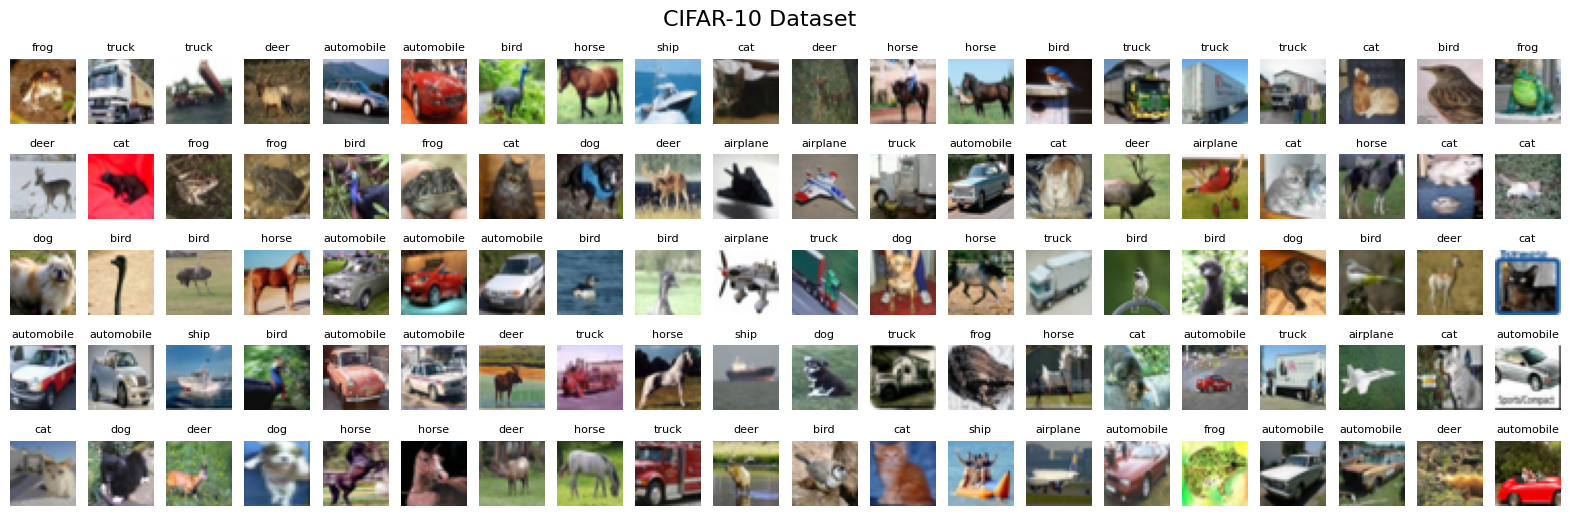

In [5]:
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

plt.figure(figsize=(20, 6))
plt.suptitle("CIFAR-10 Dataset", fontsize=16, y=0.95)
for i in range(100):
    plt.subplot(5, 20, i + 1)
    plt.imshow(train_data.data[i])
    plt.title(classes[train_data.targets[i]], fontsize=8)
    plt.axis("off")
plt.show()


Hier sieht man einige Beispiele für Trainingsdaten im Datensatz.

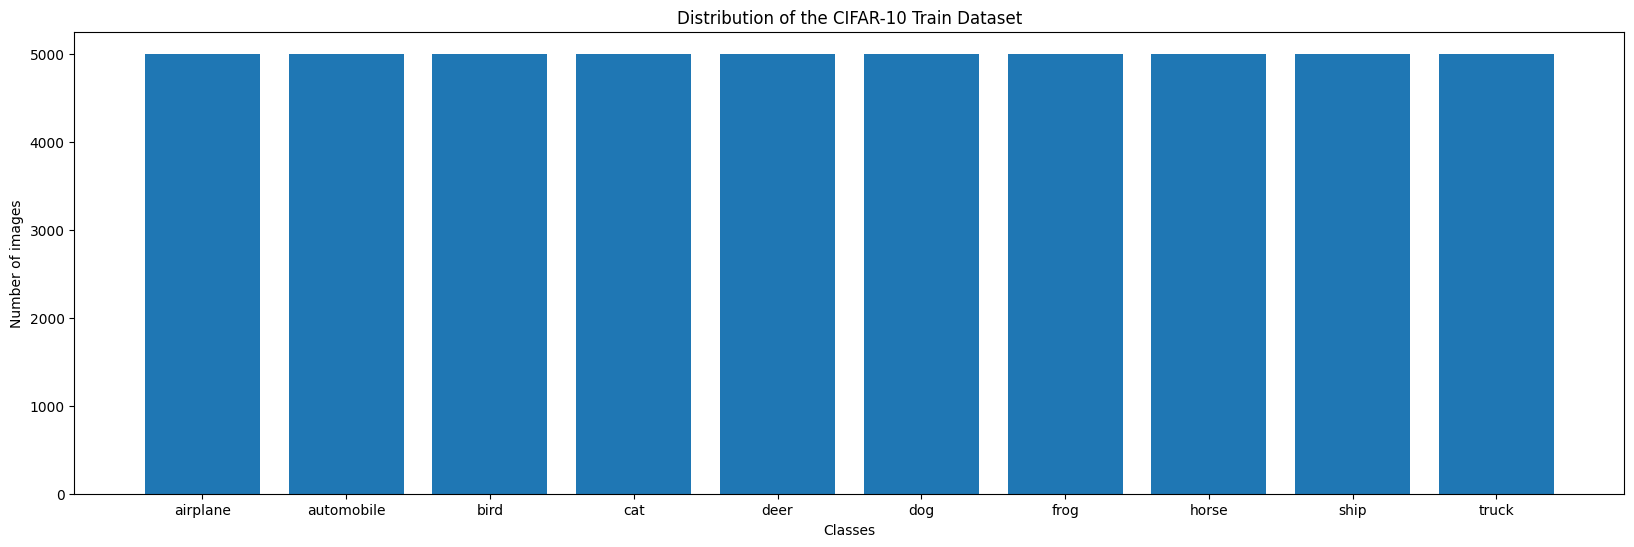

In [6]:
plt.figure(figsize=(20, 6))
plt.bar(classes, np.bincount(train_data.targets))
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.title("Distribution of the CIFAR-10 Train Dataset")
plt.show()


Hier sieht man die Distribution der Klassen im Trainingsdatensatz. Wie man erkennen kann, sind die Klassen nicht gleichmässig vertreten mit je 5000 Beispielen pro Klasse.

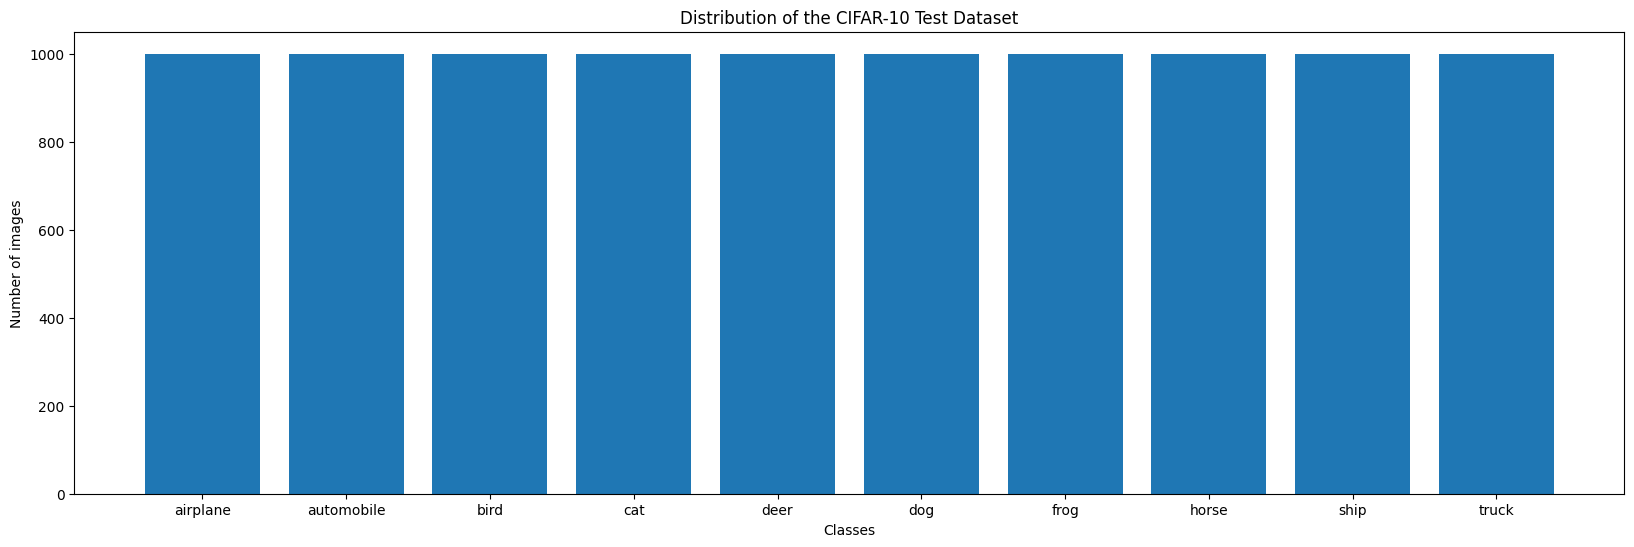

In [7]:
plt.figure(figsize=(20, 6))
plt.bar(classes, np.bincount(val_data.targets))
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.title("Distribution of the CIFAR-10 Test Dataset")
plt.show()


Bei den Testdaten sieht es ähnlich aus. Für jede Klasse gibt es 1000 Beispiele.

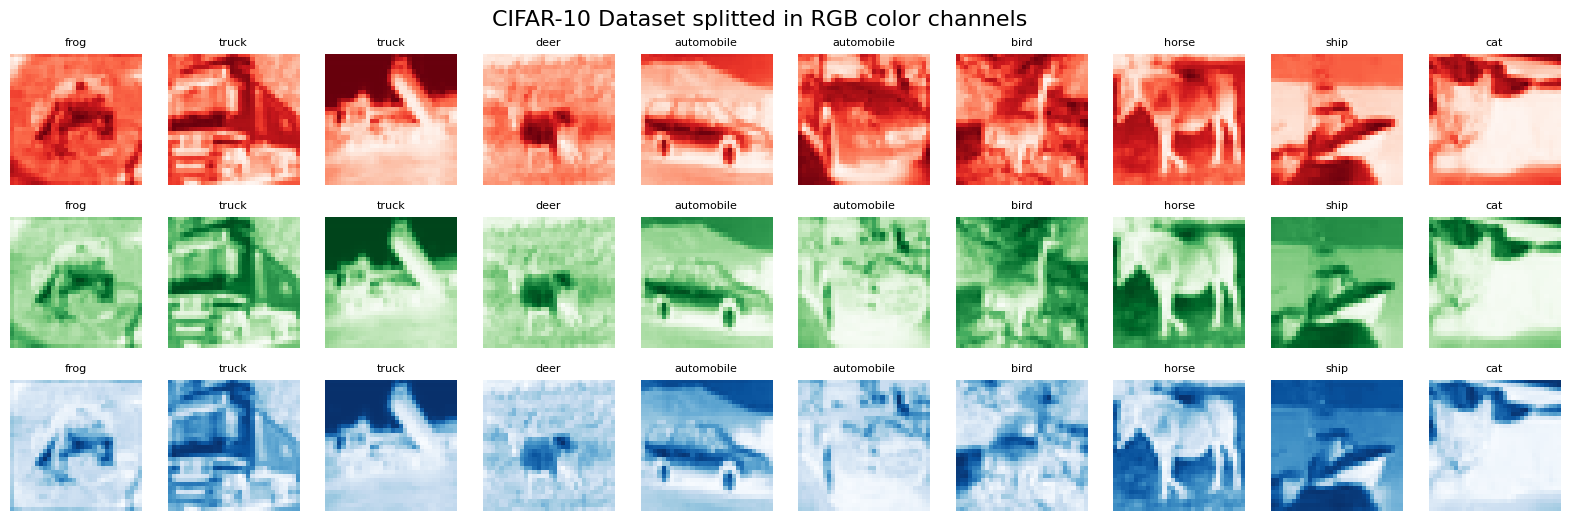

In [8]:
plt.figure(figsize=(20, 6))
plt.suptitle("CIFAR-10 Dataset splitted in RGB color channels", fontsize=16, y=0.95)
for i in range(10):
    # red channel
    plt.subplot(3, 10, i + 1)
    plt.imshow(train_data.data[i, :, :, 0], cmap="Reds")
    plt.title(classes[train_data.targets[i]], fontsize=8)
    plt.axis("off")
    # green channel
    plt.subplot(3, 10, i + 11)
    plt.imshow(train_data.data[i, :, :, 1], cmap="Greens")
    plt.title(classes[train_data.targets[i]], fontsize=8)
    plt.axis("off")
    # blue channel
    plt.subplot(3, 10, i + 21)
    plt.imshow(train_data.data[i, :, :, 2], cmap="Blues")
    plt.title(classes[train_data.targets[i]], fontsize=8)
    plt.axis("off")
plt.show()


Hier wurden 10 Datensätze in ihren 3 Farbkanälen dargestellt. Es sind nur kleine Unterschiede zwischen den einzelnen Datensätzen zu erkennen.

In [9]:
# 2.

# normalize the data
# normalisation is not necessary, because all the images were already normalized on import

# rescale the data
# rescaling is not necessary, because ALL the images are already 32x32x3 pixels


## Schritt 3: Aufbau Modellierung 

1. Lege fest, wie (mit welchen Metriken) Du Modelle evaluieren möchtest. 
Berücksichtige auch den Fehler in der Schätzung dieser Metriken.  

2. Implementiere Basisfunktionalität, um Modelle zu trainieren und gegeneinander zu 
evaluieren.  
Empfehlenswert ist die Verwendung einer geeigneten MLOps Plattform (z.B. W&B) 

3. Teste Modelle und Trainingsfunktionalität, indem Du nur mit einem einzigen Sample 
oder einem Batch trainierst. Damit bekommst Du zwar Overfitting, aber auch einen 
guten Test, der zeigt dass Information aus den Daten aufgenommen werden kann. 

### Antwort
#### 3.1

Ich will für die Evaluierung der Modelle die Accuracy und den F1 Macro Score verwenden.
Die Accuracy nutzen wir, um zu sehen, wie viel Prozent der Bilder richtig klassifiziert wurden.
Den F1 (Macro) Score nutzen wir, um zu sehen, ob der Kompromiss zwischen Precision und Recall gut ist.

#### 3.2

```python
# Weights & Biases Setup
sweep_config = {
    "method": "grid",
    "name": "sweep",
    "metric": {
        "name": "val_acc_epoch",
        "goal": "maximize",
    },
    "parameters": {
        "epochs": {"values": [10]},
        "batch_size": {"values": [16]},
        "batch_norm": {"values": [False]},
        "learning_rate": {"values": [0.03]},
        "optimizer": {"values": ["SGD"]},
        "loss_function": {"values": ["CrossEntropyLoss"]},
        "weight_decay": {"values": [0.0]},  # L2 regularization
        "momentum": {"values": [0.0]},
        "weights_init_type": {
            "values": [
                "default",
                "xavier_normal",
                "xavier_uniform",
                "kaiming_normal",
                "kaiming_uniform",
            ]
        },
        "model": {"values": ["CNN_singlebatch"]},
        "device": {"values": [device]},
    },
}

# setup wandb sweep
sweep_id = wandb.sweep(
   sweep=sweep_config, project="fhnw-del-mc1", entity="gabrieltorresgamez"
)

# setup model manager
manager = Manager(
    train_data=train_data,
    val_data=val_data,
)

# run sweep, cnn_singlebatch
wandb.agent(sweep_id, function=manager.run)
```

##### Ausgeführter Run:
https://wandb.ai/gabrieltorresgamez/fhnw-del-mc1/sweeps/lwhgo1xb

Verwendeter Code befindet sich im Ordner "Schritt 3.2, 3.3 und 4.1a"

#### 3.3

Bei der Konfiguration haben wir definiert "CNN_singlebatch" als Modell zu wählen.

In diesem Modell wird wie in der Aufgabe erwähnt, nur mit einem Batch Trainingsdaten und Validierungsdaten gearbeitet.

# Schritt 4: Evaluation 

Bei der Evaluation ist darauf zu achten, dass das Vorgehen stets möglichst reflektiert 
erfolgt und versucht wird, die Ergebnisse zu interpretieren. Am Schluss soll auch ein 
Fazit gezogen werden, darüber welche Variante am besten funktioniert. 

1. Training mit SGD, ohne REG, ohne BN:  

    Untersuche verschiedene Modelle unterschiedlicher Komplexität, welche geeignet 
    sein könnten, um das Klassifikationsproblem zu lösen. Verwende Stochastic Gradient 
    Descent - ohne Beschleunigung, ohne Regularisierung (REG) und ohne Batchnorm 
    (BN). Überlege Dir für jeden Fall, wie die Gewichte initialisiert werden sollen.

        a) Für jedes Modell mit gegebener Anzahl Layer und Units pro Layer führe ein 
        sorgfältiges Hyper-Parameter-Tuning durch (Lernrate, Batch-Grösse). Achte 
        stets darauf, dass das Training stabil läuft. Merke Dir bei jedem Training, den 
        Loss, die Performance Metrik(en) inkl. Schätzfehler, die verwendete Anzahl 
        Epochen, Lernrate und Batch-Grösse. 

        b) Variiere die Anzahl Layer und Anzahl Units pro Layer, um eine möglichst gute 
        Performance zu erreichen. Falls auch CNNs (ohne Transfer-Learning) 
        verwendet werden variiere auch Anzahl Filter, Kernel-Grösse, Stride, Padding. 
        
        c) Fasse die Ergebnisse zusammen in einem geeigneten Plot, bilde eine 
        Synthese und folgere, welche Modell-Komplexität Dir am sinnvollsten 
        erscheint

2. Nutzen der Regularisierung 

    Ziehe nun verschiedene Regularisierungsmethoden bei den MLP Layern in Betracht:  
    
        a) L1/L2 Weight Penalty 
        
        b) Dropout 
    
    Evaluiere den Nutzen der Regularisierung, auch unter Berücksichtigung 
    verschiedener Regularisierungsstärken.  
    Beschreibe auch kurz, was allgemein das Ziel von Regularisierungsmethoden ist 
    (Regularisierung im Allgemeinen, sowie auch Idee der einzelnen Methoden). 
    Inwiefern wird dieses Ziel im gegebenen Fall erreicht?  

3. Nutzen von Batchnorm BN (ohne REG, mit SGD) 

    Evaluiere, ob Batchnorm etwas bringt. Beschreibe kurz, was die Idee von BN ist, 
    wozu es helfen soll.

4. Nutzen von Adam (ohne BN, ohne / mit REG) 

    Evaluiere, ob Du mit Adam bessere Resultate erzielen kannst. 

### Antwort 
#### 4.1a) Berechnung des besten Modells

```python
sweep_config = {
    "method": "grid",
    "name": "sweep",
    "metric": {
        "name": "val_acc_epoch",
        "goal": "maximize",
    },
    "parameters": {
        "epochs": {"values": [10]},
        "batch_size": {"values": [32, 64, 128]},
        "batch_norm": {"values": [False]},
        "learning_rate": {"values": [0.03, 0.01]},
        "optimizer": {"values": ["SGD"]},
        "loss_function": {"values": ["CrossEntropyLoss"]},
        "weight_decay": {"values": [0.0]},  # L2 regularization
        "momentum": {"values": [0.0]},
        "weights_init_type": {
            "values": [
                "default",
                "kaiming_uniform",
                "kaiming_normal",
                "xavier_uniform",
                "xavier_normal",
            ]
        },
        "model": {"values": ["CNN_simple", "CNN", "MLP", "SE_ResNeXt_50"]},
        "device": {"values": [device]},
    },
}

# setup wandb sweep
sweep_id = wandb.sweep(
    sweep=sweep_config, project="fhnw-del-mc1", entity="gabrieltorresgamez"
)

# setup model manager
manager = Manager(
    train_data=train_data,
    val_data=val_data,
)

# run sweep
wandb.agent(sweep_id, function=manager.run)
```
##### Ausgeführter run:
https://wandb.ai/gabrieltorresgamez/fhnw-del-mc1/sweeps/nm5rptn0

Verwendeter Code befindet sich im Ordner "Schritt 3.2, 3.3 und 4.1a"

#### 4.1a) Berechnung des Schätzfehlers

Ergebnisse sind im Report zu finden: <a href="https://wandb.ai/gabrieltorresgamez/fhnw-del-mc1/reports/FHNW-DEL-MC1--VmlldzozOTU5NDcx#4.1a)">https://wandb.ai/gabrieltorresgamez/fhnw-del-mc1/reports/FHNW-DEL-MC1--VmlldzozOTU5NDcx#4.1a)</a>

Zum besten Modell berechnen wir nun den Schätzfehler.
Dazu spalten wir den Trainingsdatensatz anhand von K-Fold Cross Validation in K Teile auf.
Wir verwenden K=10 und berechnen den Schätzfehler anhand der 10 Folds.

```python
n_folds = 10

folds = torch.utils.data.random_split(
    train_data,  # split the train data
    [len(train_data) // n_folds] * n_folds,  # split the data in n equally sized folds
    generator=torch.Generator().manual_seed(42),  # set the seed for reproducibility
)

sweep_config = {
    "method": "grid",
    "name": "sweep",
    "metric": {
        "name": "val_acc_epoch",
        "goal": "maximize",
    },
    "parameters": {
        "epochs": {"values": [10]},
        "batch_size": {"values": [32]},
        "batch_norm": {"values": [False]},
        "learning_rate": {"values": [0.03]},
        "optimizer": {"values": ["SGD"]},
        "loss_function": {"values": ["CrossEntropyLoss"]},
        "weight_decay": {"values": [0.0]},
        "momentum": {"values": [0.0]},
        "weights_init_type": {
            "values": [
                "kaiming_normal",
            ]
        },
        "model": {"values": ["CNN"]},
        "device": {"values": [device]},
    },
}

# train the model with 4 folds and validate it with the remaining fold
for i in range(n_folds):
    print(f"Fold {i + 1} of {n_folds}")

    train_fold = torch.utils.data.ConcatDataset(folds[:i] + folds[i + 1 :])
    val_fold = folds[i]

    manager = Manager(
        train_data=train_fold,
        val_data=val_fold,
    )

    sweep_id = wandb.sweep(
        sweep=sweep_config, project="fhnw-del-mc1", entity="gabrieltorresgamez"
    )

    # run sweep
    wandb.agent(sweep_id, function=manager.run)
````
##### Ausgeführte sweeps: 

https://wandb.ai/gabrieltorresgamez/fhnw-del-mc1/sweeps/rxbyyf1r

https://wandb.ai/gabrieltorresgamez/fhnw-del-mc1/sweeps/z4rgihpg

https://wandb.ai/gabrieltorresgamez/fhnw-del-mc1/sweeps/u0yfyq4o

https://wandb.ai/gabrieltorresgamez/fhnw-del-mc1/sweeps/zv0jpnru

https://wandb.ai/gabrieltorresgamez/fhnw-del-mc1/sweeps/hmil1gnx

https://wandb.ai/gabrieltorresgamez/fhnw-del-mc1/sweeps/3uzpdlol

https://wandb.ai/gabrieltorresgamez/fhnw-del-mc1/sweeps/2qb6u996

https://wandb.ai/gabrieltorresgamez/fhnw-del-mc1/sweeps/e3a116gy

https://wandb.ai/gabrieltorresgamez/fhnw-del-mc1/sweeps/yahy4fwh

https://wandb.ai/gabrieltorresgamez/fhnw-del-mc1/sweeps/ky0hkzdj
